In [3]:
#!/usr/bin/env python3
import warnings
from pathlib import Path
from typing import Dict, List, Tuple

import hydra
import matplotlib as mpl
import numpy as np
import pytorch_lightning as pl
import torch
from hydra.utils import instantiate
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from torch import Tensor
from tqdm import tqdm

from bliss import generate, reporting
from bliss.catalog import FullCatalog, TileCatalog
from bliss.datasets.galsim_galaxies import GalsimBlends
from bliss.datasets.sdss import convert_mag_to_flux
from bliss.encoder import Encoder
from bliss.models.decoder import ImageDecoder
from bliss.models.galaxy_net import OneCenteredGalaxyAE
from bliss.models.psf_decoder import PSFDecoder
from bliss.plotting import BlissFigure, plot_image, scatter_shade_plot
from bliss.reporting import compute_bin_metrics, get_boostrap_precision_and_recall, match_by_locs

from hydra import compose, initialize
from hydra.utils import instantiate

ALL_FIGS = ("single_gal", "blend_gal", "toy")

pl.seed_everything(42)


Global seed set to 42


42

In [23]:
%matplotlib inline


In [7]:
def _load_models(cfg, device):
    # load models required for reconstructions.

    location = instantiate(cfg.models.detection_encoder).to(device).eval()
    location.load_state_dict(
        torch.load(cfg.plots.location_checkpoint, map_location=location.device)
    )

    binary = instantiate(cfg.models.binary).to(device).eval()
    binary.load_state_dict(torch.load(cfg.plots.binary_checkpoint, map_location=binary.device))

    galaxy = instantiate(cfg.models.galaxy_encoder).to(device).eval()
    galaxy.load_state_dict(torch.load(cfg.plots.galaxy_checkpoint, map_location=galaxy.device))

    n_images_per_batch = cfg.plots.encoder.n_images_per_batch
    n_rows_per_batch = cfg.plots.encoder.n_rows_per_batch
    encoder = Encoder(
        location.eval(),
        binary.eval(),
        galaxy.eval(),
        n_images_per_batch=n_images_per_batch,
        n_rows_per_batch=n_rows_per_batch,
    )
    encoder = encoder.to(device)
    decoder: ImageDecoder = instantiate(cfg.models.decoder).to(device).eval()
    return encoder, decoder


In [8]:
with initialize(config_path="../config/", version_base=None):
    cfg = compose("config")


In [11]:
device = "cuda:0"
encoder, decoder = _load_models(cfg, device)


In [14]:
blends_ds = instantiate(cfg.plots.galsim_blends) # need it to draw images


In [15]:
slen = 44


In [51]:
bp = encoder.detection_encoder.border_padding
tile_slen = encoder.detection_encoder.tile_slen
size = 44 + 2 * bp
blends_ds.slen = slen
blends_ds.decoder.slen = slen
assert slen / tile_slen % 2 == 1, "Need odd number of tiles to center galaxy."

# now separations between galaxies to be considered (in pixels)
# for efficiency, we set the batch_size equal to the number of separations
seps = torch.arange(0, 10, 0.1)
batch_size = len(seps)

# Params: total_flux, disk_frac, beta_radians, disk_q, disk_a, bulge_q, bulge_a
# first centered galaxy, then moving one.
n_sources = 2
flux1, flux2 = 1e5, 3e4
gparams = torch.tensor(
    [
        [flux1, 1.0, torch.pi / 4, 0.7, 1.5, 0, 0],
        [flux2, 1.0, 3 * torch.pi / 4, 0.7, 1.0, 0, 0],
    ],
)
gparams = gparams.reshape(1, 2, 7).expand(batch_size, 2, 7)

# create full catalogs (need separately since decoder only accepts 1 batch)
x0, y0 = 22, 22  # center plocs
images = torch.zeros(batch_size, 1, size, size)
background = torch.zeros(batch_size, 1, size, size)
plocs = torch.tensor([[[x0, y0], [x0, y0 + sep]] for sep in seps]).reshape(batch_size, 2, 2)
for ii in range(batch_size):
    ploc = plocs[ii].reshape(1, 2, 2)
    d = {
        "n_sources": torch.full((1,), n_sources),
        "plocs": ploc,
        "galaxy_bools": torch.ones(1, n_sources, 1),
        "galaxy_params": gparams[ii, None],
        "star_bools": torch.zeros(1, n_sources, 1),
        "star_fluxes": torch.zeros(1, n_sources, 1),
        "star_log_fluxes": torch.zeros(1, n_sources, 1),
    }
    full_cat = FullCatalog(slen, slen, d)
    image, _, _, _, bg = blends_ds.get_images(full_cat)
    images[ii] = image
    background[ii] = bg


In [52]:
# inference 
# predictions from encoder
tile_est = encoder.variational_mode(images, background)
recon = decoder.render_images(tile_est)
tile_est.set_all_fluxes_and_mags(decoder)
tile_est = tile_est.cpu()
recon = recon.detach().cpu() + background
residuals = (recon - images) / recon.sqrt()

# now we need to obtain flux, pred. ploc, prob. of detection in tile and std. of ploc
# for each source
params = {
    "images": images,
    "recon": recon,
    "resid": residuals,
    "seps": seps,
    "truth": {
        "flux": torch.tensor([flux1, flux2]).reshape(1, 2, 1).expand(batch_size, 2, 1),
        "ploc": plocs,
    },
    "est": {
        "prob_n_source": torch.zeros(batch_size, 2, 1),
        "flux": torch.zeros(batch_size, 2, 1),
        "ploc": torch.zeros(batch_size, 2, 2),
        "ploc_sd": torch.zeros(batch_size, 2, 2),
    },
    "tile_est": tile_est.to_dict(),
}
for ii, sep in enumerate(seps):
    # get tile_est for a single batch
    d = tile_est.to_dict()
    d = {k: v[ii, None] for k, v in d.items()}
    tile_est_ii = TileCatalog(tile_slen, d)

    ploc = plocs[ii]
    params_at_coord = tile_est_ii.get_tile_params_at_coord(ploc)
    prob_n_source = torch.exp(params_at_coord["n_source_log_probs"])
    flux = params_at_coord["fluxes"]
    ploc_sd = params_at_coord["loc_sd"] * tile_slen
    loc = params_at_coord["locs"]
    assert prob_n_source.shape == flux.shape == (2, 1)
    assert ploc_sd.shape == loc.shape == (2, 2)

    if sep < 2:
        params["est"]["prob_n_source"][ii][0] = prob_n_source[0]
        params["est"]["flux"][ii][0] = flux[0]
        params["est"]["ploc"][ii][0] = loc[0] * tile_slen + 5 * tile_slen
        params["est"]["ploc_sd"][ii][0] = ploc_sd[0]

        params["est"]["prob_n_source"][ii][1] = torch.nan
        params["est"]["flux"][ii][1] = torch.nan
        params["est"]["ploc"][ii][1] = torch.tensor([torch.nan, torch.nan])
        params["est"]["ploc_sd"][ii][1] = torch.tensor([torch.nan, torch.nan])
    else:
        bias = 5 + np.ceil((sep - 2) / 4)
        params["est"]["prob_n_source"][ii] = prob_n_source
        params["est"]["flux"][ii] = flux
        params["est"]["ploc"][ii][0] = loc[0] * tile_slen + 5 * tile_slen
        params["est"]["ploc"][ii, 1, 0] = loc[1][0] * tile_slen + 5 * tile_slen
        params["est"]["ploc"][ii, 1, 1] = loc[1][1] * tile_slen + bias * tile_slen
        params["est"]["ploc_sd"][ii] = ploc_sd


Encoding ptiles: 10it [00:00, 16.50it/s]


In [87]:
idx = 35 # index of the blend to plot
params['est']['prob_n_source'][idx], params['est']['ploc'][idx]


(tensor([[0.9984],
         [0.5399]]),
 tensor([[22.0187, 22.9450],
         [22.3270, 24.6561]]))

In [ ]:

# now try with sep 
import sep 

# measure background
im = images[idx, 0].cpu().numpy()
bkg = sep.Background(im)

# subtract background
data_sub = im - bkg

# detect objects
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)


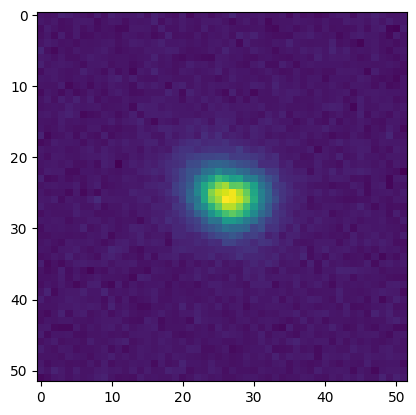

In [88]:
plt.imshow(images[idx, 0][trim:-trim, trim:-trim].cpu().numpy())


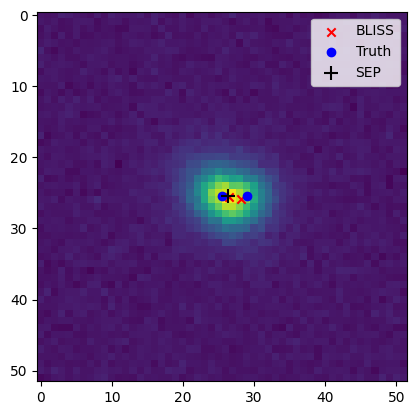

In [97]:

trim = 20


plt.imshow(images[idx, 0][trim:-trim, trim:-trim].cpu().numpy())

for ii, p in enumerate(params['est']['ploc'][idx]):
    label = 'BLISS' if ii == 0 else None
    p = p + bp - 0.5 - trim
    plt.scatter(p[1], p[0], marker='x', color='red', label=label)

for ii, p in enumerate(params['truth']['ploc'][idx]):
    label = 'Truth' if ii == 0 else None
    p = p + bp - 0.5 - trim 
    plt.scatter(p[1], p[0], marker='o', color='blue', label=label)

plt.scatter(objects['x'] - trim,objects['y']- trim, marker='+', color='black', label='SEP', s=100)

plt.legend()


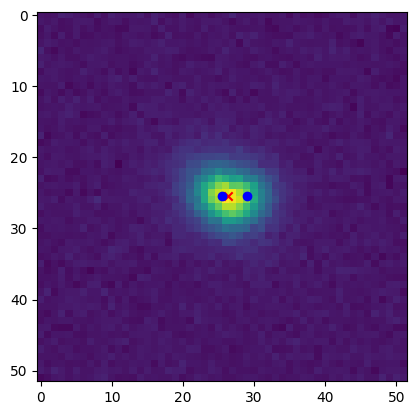

In [92]:
# plot detections centroids and truth
plt.imshow(im[trim:-trim, trim:-trim])

for p in params['truth']['ploc'][idx]:
    p = p + bp - 0.5 - trim 
    plt.scatter(p[1], p[0], marker='o', color='blue', label='truth')



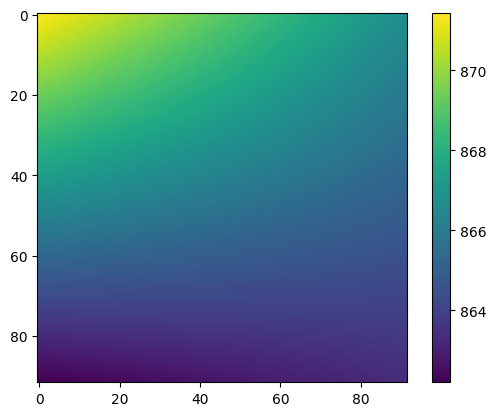

In [74]:
plt.imshow(bkg.back())
plt.colorbar()
